In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as Keras

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_path = "data"

config = {
    "batch_size": 24,
    "image_size": 256,
    "n_channels": 3,
    "shuffle": True
}

In [3]:
dataset = Keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(config["image_size"], config["image_size"]),
    batch_size=config["batch_size"],
    shuffle=config["shuffle"],
)

Found 21104 files belonging to 15 classes.


In [4]:
# size of dataset = num_files(20638) / batch_size(32) = 645 
len(dataset)

880

In [5]:
class_names = dataset.class_names

In [6]:
train_config = {
    "epochs": 10,
    "lr": 5e-4,
    "fine_tuning_epochs": 2,
    "train_split": 0.7,
    "test_split": 0.1,
    "shuffle": True,
    "early_stopping_patience": 3,
    "lr_sch_round": 6
}

In [7]:
def split_dataset(dataset, train_split, test_split, shuffle=False, shuffle_size=10000):
    ds_len = len(dataset)
    
    if shuffle:
        ds = dataset.shuffle(shuffle_size, seed=10)
    
    train_size = int(ds_len * train_split)
    test_size = int(ds_len * test_split)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    
    return train_ds, test_ds, val_ds

In [8]:
train_ds, test_ds, val_ds = split_dataset(
    dataset, 
    train_config["train_split"],
    train_config["test_split"], 
    shuffle=train_config["shuffle"]
)

print(f"...Train set: {len(train_ds)}")
print(f"...Val set: {len(val_ds)}")
print(f"...Test set: {len(test_ds)}")

...Train set: 616
...Val set: 176
...Test set: 88


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [10]:
INPUT_SHAPE = (config["batch_size"], config["image_size"], config["image_size"], config["n_channels"])
N_CLASSES = len(class_names)

In [11]:
inputs = Keras.layers.Input(shape=INPUT_SHAPE[1:])

x = Keras.applications.resnet.ResNet50(input_tensor=inputs, include_top=False, weights="imagenet", input_shape=INPUT_SHAPE[1:])

x.trainable = False

x = Keras.layers.GlobalAveragePooling2D()(x.output)

x = Keras.layers.Dense(256, activation="relu")(x)

x = Keras.layers.Dense(256, activation="relu")(x)

outputs = Keras.layers.Dense(N_CLASSES, activation="softmax")(x)

model = Keras.Model(inputs, outputs)

In [12]:
model.build(input_shape=INPUT_SHAPE)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [14]:
model.compile(
    optimizer=Keras.optimizers.Adam(learning_rate=train_config["lr"]),
    loss=Keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [15]:
callbacks = []

early_stopping = Keras.callbacks.EarlyStopping(monitor="val_loss", patience=train_config["early_stopping_patience"])
callbacks.append(early_stopping)

def lr_sch(epoch, lr):
    if epoch < train_config["lr_sch_round"] :
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = Keras.callbacks.LearningRateScheduler(lr_sch)
callbacks.append(lr_scheduler)

In [16]:
tf.get_logger().setLevel('ERROR')
history = model.fit(
    train_ds, 
    batch_size=config["batch_size"], 
    epochs=train_config["epochs"], 
    validation_data=val_ds, 
    callbacks=callbacks
).history

Epoch 1/10
616/616 [==============================] - 130s 157ms/step - loss: 0.4504 - accuracy: 0.8577 - val_loss: 0.1999 - val_accuracy: 0.9368 - lr: 5.0000e-04
Epoch 2/10
616/616 [==============================] - 78s 127ms/step - loss: 0.1710 - accuracy: 0.9426 - val_loss: 0.1341 - val_accuracy: 0.9524 - lr: 5.0000e-04
Epoch 3/10
616/616 [==============================] - 73s 118ms/step - loss: 0.1094 - accuracy: 0.9630 - val_loss: 0.1345 - val_accuracy: 0.9555 - lr: 5.0000e-04
Epoch 4/10
616/616 [==============================] - 72s 116ms/step - loss: 0.0849 - accuracy: 0.9716 - val_loss: 0.0817 - val_accuracy: 0.9725 - lr: 5.0000e-04
Epoch 5/10
616/616 [==============================] - 79s 128ms/step - loss: 0.0637 - accuracy: 0.9785 - val_loss: 0.0492 - val_accuracy: 0.9837 - lr: 5.0000e-04
Epoch 6/10
616/616 [==============================] - 77s 125ms/step - loss: 0.0516 - accuracy: 0.9825 - val_loss: 0.0442 - val_accuracy: 0.9844 - lr: 5.0000e-04
Epoch 7/10
616/616 [=======

In [17]:
import gc
gc.collect()

4

In [19]:
# fine tuning
# base_model.trainable = True

# model.compile(
#     optimizer=Keras.optimizers.Adam(learning_rate=1e-7),
#     loss=Keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"]
# )

# model.fit(
#     train_ds, 
#     batch_size=config["batch_size"], 
#     epochs=train_config["fine_tuning_epochs"], 
#     validation_data=val_ds, 
# )

Text(0.5, 1.0, 'Training Validation Loss')

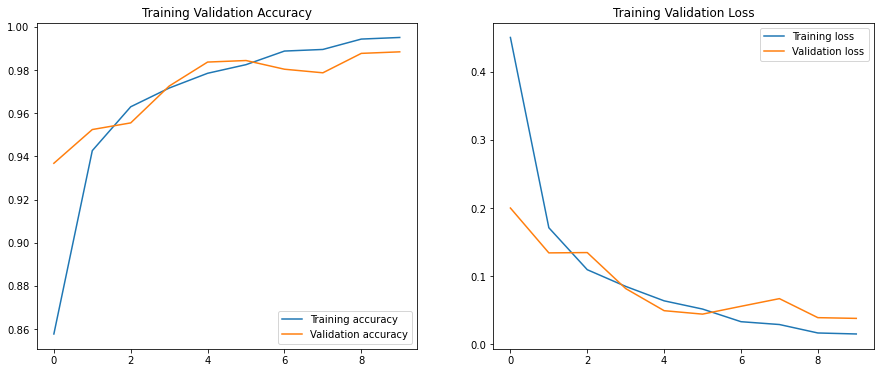

In [20]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history["accuracy"])), history["accuracy"], label="Training accuracy")
plt.plot(range(len(history["val_accuracy"])), history["val_accuracy"], label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training Validation Accuracy")


plt.subplot(1, 2, 2)
plt.plot(range(len(history["loss"])), history["loss"], label="Training loss")
plt.plot(range(len(history["val_loss"])), history["val_loss"], label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training Validation Loss")

In [21]:
score = model.evaluate(test_ds)

score

88/88 [==============================] - 33s 73ms/step - loss: 0.0541 - accuracy: 0.9862


[0.054054927080869675, 0.9861640930175781]

In [22]:
def predict(model, image, class_names=None):
    image_arr = Keras.preprocessing.image.img_to_array(image)
    image_batch = tf.expand_dims(image_arr, 0)
    predictions = model.predict(image_batch)
    predicted_output = tf.argmax(predictions[0])
    if class_names is not None:
        predicted_output = class_names[tf.argmax(predictions[0])]
    confidence_score = round(100 * predictions[0][predicted_output], 2)
    return predicted_output, confidence_score

In [23]:
def show_predictions(dataset, model, batch_num, n_images, class_names):
    for image_batch, label_batch in dataset.take(batch_num):
        for i in range(n_images):
            plt.subplot(int(n_images/3), 3, i + 1)
            pred, confi = predict(model, image_batch[i].numpy())
            if type(pred) == "string":
                pred_class = pred
            else:
                pred_class = class_names[pred]
            actual_class = class_names[label_batch[i].numpy()]
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(f"Actual: {actual_class} \n Predicted: {pred_class} \n Confidence: {confi}%")
            plt.axis("off")

1/1 [==============================] - 0s 16ms/step


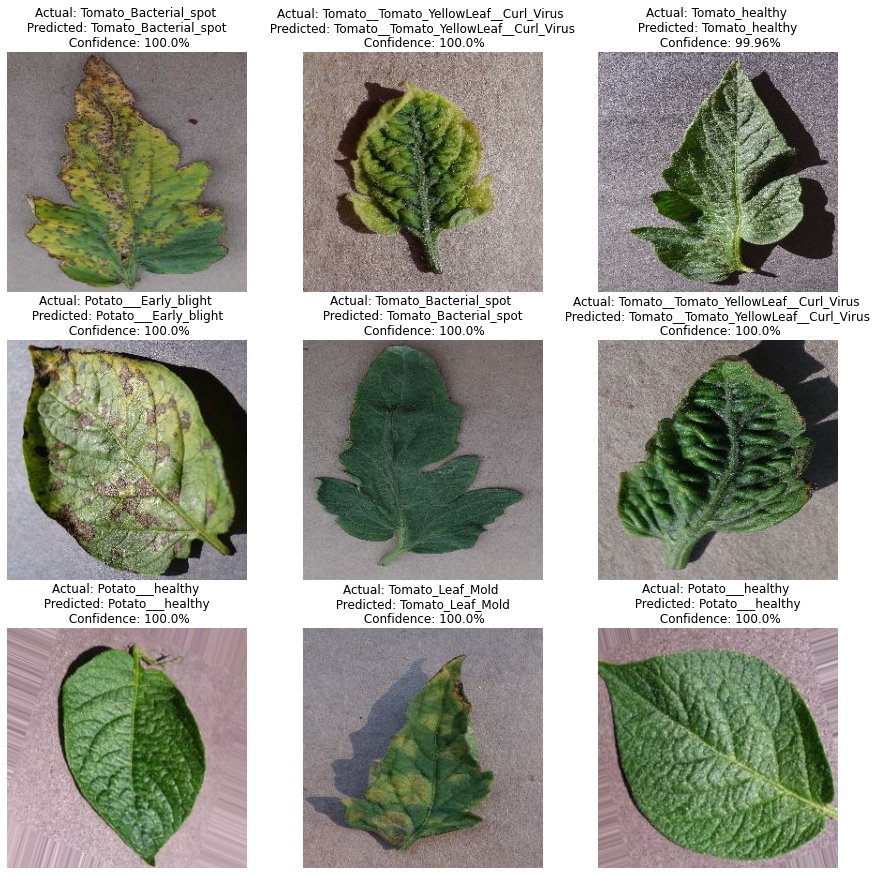

In [24]:
plt.figure(figsize=(15, 15))
show_predictions(test_ds, model, batch_num=1, n_images=9, class_names=class_names)

In [25]:
model_version = max([int(i) for i in os.listdir("models")]) + 1
model.save(f"models/{model_version}")